In [1]:
from itertools import compress
import matplotlib.pyplot as plt
import numpy as np
import os
import mne
import mne_nirs
import snirf
from mne_nirs.statistics import run_glm
import statsmodels.formula.api as smf
import pandas as pd

# Function to extract trial treatment from filename
def extract_trial_treatment(snirf_file):
    filename = os.path.basename(snirf_file)
    filename_parts = filename.replace('.snirf', '').split('_')
    
    return filename_parts[1]  # Assuming treatment is always the second part

# Function to extract participant ID from filename
def extract_participant_id(snirf_file):
    filename = os.path.basename(snirf_file)
    filename_parts = filename.replace('.snirf', '').split('_')
    
    return filename_parts[2]  # Assuming participant ID is always the third part

def extract_trial_name(snirf_file):
    filename = os.path.basename(snirf_file)
    filename_parts = filename.replace('.snirf', '').split('_')
    
    return f"{filename_parts[1]}_{filename_parts[2]}"  # treatment_participantID

def raw_intensity_to_hemo(snirf_file):
    """Process a single SNIRF file through the complete pipeline"""
    
    trial_name = extract_trial_name(snirf_file)
    print(f"Loading data from: {snirf_file} (Trial: {trial_name})")
    
    # Load and process data (following your original cells 1-12)
    raw_intensity = mne.io.read_raw_snirf(snirf_file, optode_frame='unknown', verbose="info")
    raw_intensity.load_data()

    # Resample
    print(f"Data shape: {raw_intensity.get_data().shape}")
    print(f"Sampling frequency: {raw_intensity.info['sfreq']} Hz")
    raw_intensity.resample(5)
    
    # Convert to hemoglobin
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose=False)
    raw_od_corrected = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od, verbose=False)
    raw_od_filtered = raw_od_corrected.copy().filter(0.01, 0.25, method='fir', fir_design='firwin', verbose=False)
    raw_hemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_filtered, ppf=0.1,)
    

    return raw_hemo, trial_name



In [2]:

# Extract averages for each block, trial, and channel
def get_hemoglobin_averages(raw_haemo, trial_name):
    """
    Extract average oxy and deoxy hemoglobin for each block and channel
    
    Parameters:
    -----------
    raw_haemo : mne.io.Raw
        Hemoglobin data (converted with beer_lambert_law)
    trial_name : str
        Name of the trial
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with average oxy/deoxy hemoglobin per block/channel
    """
    
    # Get the data
    data = raw_haemo.get_data()  # shape: (n_channels, n_times)
    ch_names = raw_haemo.ch_names
    
    # Get event information if available
    events, event_ids = mne.events_from_annotations(raw_haemo)
    
    # Create results list
    results = []
    
    if len(events) > 0:
        # Process each event/block
        for event_idx, (event_sample, duration, event_id) in enumerate(events):
            # Get event label
            event_label = None
            for label, id_val in event_ids.items():
                if id_val == event_id:
                    event_label = label
                    break
            
            # Define block window (e.g., from event to next event or fixed duration)
            block_start = event_sample
            if event_idx < len(events) - 1:
                block_end = events[event_idx + 1][0]
            else:
                block_end = len(data[0])
            
            # Extract data for this block
            block_data = data[:, block_start:block_end]
            
            # Calculate mean for each channel
            for ch_idx, ch_name in enumerate(ch_names):
                # Determine if it's HbO or HbR
                if 'hbo' in ch_name.lower():
                    hb_type = 'HbO'
                elif 'hbr' in ch_name.lower():
                    hb_type = 'HbR'
                else:
                    hb_type = 'Unknown'
                
                mean_value = np.mean(block_data[ch_idx])
                
                results.append({
                    'Trial': trial_name,
                    'Block': event_label if event_label else f'Block_{event_idx}',
                    'Channel': ch_name,
                    'HbType': hb_type,
                    'Mean_Value': mean_value,
                    'Std_Value': np.std(block_data[ch_idx]),
                    'Block_Duration_s': (block_end - block_start) / raw_haemo.info['sfreq']
                })
    else:
        # If no events, treat entire recording as one block
        for ch_idx, ch_name in enumerate(ch_names):
            if 'hbo' in ch_name.lower():
                hb_type = 'HbO'
            elif 'hbr' in ch_name.lower():
                hb_type = 'HbR'
            else:
                hb_type = 'Unknown'
            
            mean_value = np.mean(data[ch_idx])
            
            results.append({
                'Trial': trial_name,
                'Block': 'Entire_Recording',
                'Channel': ch_name,
                'HbType': hb_type,
                'Mean_Value': mean_value,
                'Std_Value': np.std(data[ch_idx]),
                'Block_Duration_s': len(data[0]) / raw_haemo.info['sfreq']
            })
    
    return pd.DataFrame(results)

# Process the first file
averages_df = get_hemoglobin_averages(*raw_intensity_to_hemo("..\\data\\raw\\20250625_N_2.snirf"))
print(averages_df.head(10))


Loading data from: ..\data\raw\20250625_N_2.snirf (Trial: N_2)

Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250625_N_2.snirf
Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250625_N_2.snirf
Found jitter of 0.000000% in sample times.
Found jitter of 0.000000% in sample times.


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:39: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2025-06-25
  raw_intensity = mne.io.read_raw_snirf(snirf_file, optode_frame='unknown', verbose="info")


Reading 0 ... 17540  =      0.000 ...  2155.315 secs...
Data shape: (408, 17541)
Sampling frequency: 8.138020833333334 Hz
Data shape: (408, 17541)
Sampling frequency: 8.138020833333334 Hz


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:48: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose=False)


Used Annotations descriptions: [np.str_('Design problem context'), np.str_('Generate stakeholder needs'), np.str_('Prioritize stakeholder needs'), np.str_('Stakeholder identification'), np.str_('Thinkaloud practice AUT'), np.str_('Thinkaloud practice basic math'), np.str_('Thinkalound practice anagram')]
  Trial                           Block     Channel HbType  Mean_Value  \
0   N_2  Thinkaloud practice basic math   S8_D1 hbo    HbO   -0.000010   
1   N_2  Thinkaloud practice basic math   S1_D4 hbo    HbO    0.000033   
2   N_2  Thinkaloud practice basic math   S8_D9 hbo    HbO    0.000037   
3   N_2  Thinkaloud practice basic math  S2_D25 hbo    HbO    0.000224   
4   N_2  Thinkaloud practice basic math   S3_D1 hbo    HbO    0.000010   
5   N_2  Thinkaloud practice basic math   S2_D8 hbo    HbO    0.000018   
6   N_2  Thinkaloud practice basic math   S7_D5 hbo    HbO   -0.000008   
7   N_2  Thinkaloud practice basic math   S6_D4 hbo    HbO   -0.000005   
8   N_2  Thinkaloud practice

In [3]:

# Process all SNIRF files and combine results
snirf_files = [
    "..\\data\\raw\\20250624_MRSA_1.snirf",
    "..\\data\\raw\\20250625_N_2.snirf",
    "..\\data\\raw\\20250630_R_3.snirf"
]

all_averages = []

for snirf_file in snirf_files:
    try:
        raw_hemo, trial_name = raw_intensity_to_hemo(snirf_file)
        averages_df = get_hemoglobin_averages(raw_hemo, trial_name)
        all_averages.append(averages_df)
        print(f"✓ Processed: {trial_name} ({len(averages_df)} measurements)\n")
    except Exception as e:
        print(f"✗ Error processing {snirf_file}: {e}\n")

# Combine all results
combined_df = pd.concat(all_averages, ignore_index=True)

print(f"\n{'='*80}")
print(f"Combined Results: {len(combined_df)} total measurements")
print(f"{'='*80}")
print(combined_df.head(20))


Loading data from: ..\data\raw\20250624_MRSA_1.snirf (Trial: MRSA_1)
Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250624_MRSA_1.snirf

Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250624_MRSA_1.snirf
Found jitter of 0.000000% in sample times.
Found jitter of 0.000000% in sample times.
Reading 0 ... 19631  =      0.000 ...  2453.875 secs...
Reading 0 ... 19631  =      0.000 ...  2453.875 secs...
Data shape: (408, 19632)
Sampling frequency: 8.0 Hz
Data shape: (408, 19632)
Sampling frequency: 8.0 Hz


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:48: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose=False)


Used Annotations descriptions: [np.str_('Design problem context'), np.str_('Generate stakeholder needs'), np.str_('Prioritize stakeholder needs'), np.str_('Stakeholder identification'), np.str_('Stakeholder personas')]
✓ Processed: MRSA_1 (2040 measurements)

Loading data from: ..\data\raw\20250625_N_2.snirf (Trial: N_2)
Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250625_N_2.snirf
✓ Processed: MRSA_1 (2040 measurements)

Loading data from: ..\data\raw\20250625_N_2.snirf (Trial: N_2)
Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250625_N_2.snirf
Found jitter of 0.000000% in sample times.
Found jitter of 0.000000% in sample times.


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:39: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2025-06-25
  raw_intensity = mne.io.read_raw_snirf(snirf_file, optode_frame='unknown', verbose="info")


Reading 0 ... 17540  =      0.000 ...  2155.315 secs...
Data shape: (408, 17541)
Sampling frequency: 8.138020833333334 Hz
Data shape: (408, 17541)
Sampling frequency: 8.138020833333334 Hz


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:48: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose=False)


Used Annotations descriptions: [np.str_('Design problem context'), np.str_('Generate stakeholder needs'), np.str_('Prioritize stakeholder needs'), np.str_('Stakeholder identification'), np.str_('Thinkaloud practice AUT'), np.str_('Thinkaloud practice basic math'), np.str_('Thinkalound practice anagram')]
✓ Processed: N_2 (2856 measurements)

Loading data from: ..\data\raw\20250630_R_3.snirf (Trial: R_3)
Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250630_R_3.snirf
✓ Processed: N_2 (2856 measurements)

Loading data from: ..\data\raw\20250630_R_3.snirf (Trial: R_3)
Loading c:\Users\jdtull\Documents\CRED\Projects\Design Cognition\Design-Cognition\cred_fnirs_toolkit\notebooks\..\data\raw\20250630_R_3.snirf
Found jitter of 0.000000% in sample times.
Found jitter of 0.000000% in sample times.


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:39: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of 2025-06-30
  raw_intensity = mne.io.read_raw_snirf(snirf_file, optode_frame='unknown', verbose="info")


Reading 0 ... 16650  =      0.000 ...  2045.957 secs...
Data shape: (408, 16651)
Sampling frequency: 8.138 Hz
Data shape: (408, 16651)
Sampling frequency: 8.138 Hz


C:\Users\jdtull\AppData\Local\Temp\ipykernel_27184\3445241769.py:48: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity, verbose=False)


Used Annotations descriptions: [np.str_('Design problem context'), np.str_('Generate stakeholder needs'), np.str_('Prioritize stakeholder needs'), np.str_('Stakeholder identification'), np.str_('Stakeholder personas'), np.str_('thinkaloud practice AUT'), np.str_('thinkaloud practice anagram'), np.str_('thinkaloud practice basic math')]
✓ Processed: R_3 (3264 measurements)


================================================================================✓ Processed: R_3 (3264 measurements)


Combined Results: 8160 total measurements
Combined Results: 8160 total measurements
     Trial                   Block      Channel HbType    Mean_Value  \
0   MRSA_1  Design problem context    S8_D1 hbo    HbO  5.514084e-06   
1   MRSA_1  Design problem context    S1_D4 hbo    HbO  7.570133e-07   
2   MRSA_1  Design problem context    S8_D9 hbo    HbO -2.200322e-07   
3   MRSA_1  Design problem context   S2_D25 hbo    HbO  7.245744e-07   
4   MRSA_1  Design problem context    S3_D1 hbo    HbO  5.29

In [4]:

# Create detailed pivot table: Trial/Channel (rows) x Blocks (columns) with HbO averages
# Filter for HbO only
hbo_df = combined_df[combined_df['HbType'] == 'HbO'].copy()

# Create a unique row label combining Trial and Channel
hbo_df['Row_Label'] = hbo_df['Trial'] + ' | ' + hbo_df['Channel'].astype(str)

# Pivot: Rows = Trial/Channel, Columns = Blocks, Values = Mean HbO
detailed_pivot = hbo_df.pivot_table(
    index='Row_Label',
    columns='Block',
    values='Mean_Value',
    aggfunc='mean'
)

print("\n" + "="*100)
print("DETAILED HbO Pivot Table (Trial/Channel × Blocks)")
print("="*100)
print(detailed_pivot)
print(f"\nShape: {detailed_pivot.shape[0]} rows (trial/channel combinations) × {detailed_pivot.shape[1]} columns (blocks)")

# Save to CSV
output_csv_detailed = "..\\data\\processed\\hbo_averages_detailed_pivot.csv"
os.makedirs(os.path.dirname(output_csv_detailed), exist_ok=True)
detailed_pivot.to_csv(output_csv_detailed)
print(f"\n✓ Saved detailed pivot table to: {output_csv_detailed}")



DETAILED HbO Pivot Table (Trial/Channel × Blocks)
Block                 Design problem context  Generate stakeholder needs  \
Row_Label                                                                  
MRSA_1 | S10_D10 hbo           -8.387141e-06               -8.907724e-07   
MRSA_1 | S10_D13 hbo           -1.340711e-05               -2.333249e-06   
MRSA_1 | S10_D14 hbo            2.001884e-05               -1.795911e-06   
MRSA_1 | S10_D15 hbo           -2.951766e-06               -6.409354e-06   
MRSA_1 | S10_D16 hbo           -9.634257e-06               -5.392026e-06   
...                                      ...                         ...   
R_3 | S9_D14 hbo               -5.765779e-06               -7.260968e-06   
R_3 | S9_D15 hbo                1.522814e-05               -9.389572e-07   
R_3 | S9_D16 hbo               -3.774027e-07               -1.920015e-05   
R_3 | S9_D4 hbo                -8.039464e-07               -1.761248e-06   
R_3 | S9_D9 hbo                 3.012

In [ ]:

# Load the channel mapping file
import json

with open("..\\references\\nirsit_full_channel_map.json", 'r') as f:
    channel_map = json.load(f)

# Create a lookup dictionary: "S{source}_D{detector}" -> region
channel_to_region = {}
for entry in channel_map:
    key = f"S{entry['source']}_D{entry['detector']}"
    channel_to_region[key] = entry['region']

print(f"Loaded {len(channel_to_region)} channel mappings")
print(f"\nSample mappings:")
for i, (channel, region) in enumerate(list(channel_to_region.items())[:5]):
    print(f"  {channel} -> {region}")

# Extract S#_D# from channel names in combined_df
def extract_source_detector(channel_name):
    """Extract S#_D# pattern from channel name like 'S1_D1 hbo'"""
    import re
    match = re.search(r'S(\d+)_D(\d+)', channel_name)
    if match:
        return f"S{match.group(1)}_D{match.group(2)}"
    return None

# Add source-detector and region columns to combined_df
hbo_df_regions = combined_df[combined_df['HbType'] == 'HbO'].copy()
hbo_df_regions['Source_Detector'] = hbo_df_regions['Channel'].apply(extract_source_detector)
hbo_df_regions['Region'] = hbo_df_regions['Source_Detector'].map(channel_to_region)

unmapped = hbo_df_regions[hbo_df_regions['Region'].isna()]
if len(unmapped) > 0:
    print(f"\n⚠ Warning: {len(unmapped)} measurements with unmapped channels:")
    print(unmapped[['Channel', 'Source_Detector']].drop_duplicates())
else:
    print("\n✓ All channels successfully mapped to regions")

print(f"\nUnique regions found: {hbo_df_regions['Region'].nunique()}")
print(hbo_df_regions['Region'].value_counts())


Loaded 48 channel mappings

Sample mappings:
  S8_D1 -> Dorsolateral Prefrontal Cortex
  S1_D4 -> Dorsolateral Prefrontal Cortex
  S8_D9 -> Dorsolateral Prefrontal Cortex
  S2_D25 -> Ventrolateral Prefrontal Cortex
  S3_D1 -> Dorsolateral Prefrontal Cortex


Sample mappings:
  S8_D1 -> Dorsolateral Prefrontal Cortex
  S1_D4 -> Dorsolateral Prefrontal Cortex
  S8_D9 -> Dorsolateral Prefrontal Cortex
  S2_D25 -> Ventrolateral Prefrontal Cortex
  S3_D1 -> Dorsolateral Prefrontal Cortex

⚠ Warning: 3120 measurements with unmapped channels:
         Channel Source_Detector
48     S1_D6 hbo           S1_D6
49     S8_D7 hbo           S8_D7
50    S10_D8 hbo          S10_D8
51     S4_D5 hbo           S4_D5
52     S5_D8 hbo           S5_D8
..           ...             ...
199   S4_D27 hbo          S4_D27
200  S22_D32 hbo         S22_D32
201  S23_D31 hbo         S23_D31
202  S24_D29 hbo         S24_D29
203  S21_D30 hbo         S21_D30

[156 rows x 2 columns]
⚠ Warning: 3120 measurements with unma

In [ ]:

# Create pivot tables for each brain region
# Filter out unmapped regions
hbo_df_regions_clean = hbo_df_regions[hbo_df_regions['Region'].notna()].copy()

unique_regions = hbo_df_regions_clean['Region'].unique()

print(f"\n{'='*100}")
print(f"Creating pivot tables for {len(unique_regions)} brain regions")
print(f"{'='*100}\n")

region_pivots = {}

for region in sorted(unique_regions):
    # Filter data for this region
    region_data = hbo_df_regions_clean[hbo_df_regions_clean['Region'] == region].copy()
    
    # Create pivot table: Trial (rows) x Blocks (columns), averaged across all channels in this region
    region_pivot = region_data.pivot_table(
        index='Trial',
        columns='Block',
        values='Mean_Value',
        aggfunc='mean'  # Average across all channels in this region
    )
    
    region_pivots[region] = region_pivot
    

    safe_region_name = region.replace(' ', '_').replace('/', '_').lower()
    output_csv = f"..\\data\\processed\\hbo_region_{safe_region_name}.csv"
    region_pivot.to_csv(output_csv)
    
    print(f"✓ {region}")
    print(f"  Shape: {region_pivot.shape[0]} trials × {region_pivot.shape[1]} blocks")
    print(f"  Channels averaged: {region_data['Source_Detector'].nunique()}")
    print(f"  Saved to: hbo_region_{safe_region_name}.csv\n")

print(f"{'='*100}")
print(f"✓ Created {len(region_pivots)} region-based pivot tables")
print(f"{'='*100}")



Creating pivot tables for 4 brain regions

✓ Dorsolateral Prefrontal Cortex
  Shape: 3 trials × 11 blocks
  Channels averaged: 16
  Saved to: hbo_region_dorsolateral_prefrontal_cortex.csv

✓ Frontopolar Prefrontal Cortex
  Shape: 3 trials × 11 blocks
  Channels averaged: 16
  Saved to: hbo_region_frontopolar_prefrontal_cortex.csv

✓ Orbitofrontal Cortex
  Shape: 3 trials × 11 blocks
  Channels averaged: 10
  Saved to: hbo_region_orbitofrontal_cortex.csv

✓ Ventrolateral Prefrontal Cortex
  Shape: 3 trials × 11 blocks
  Channels averaged: 6
  Saved to: hbo_region_ventrolateral_prefrontal_cortex.csv

✓ Created 4 region-based pivot tables



Creating heatmaps for 4 brain regions

✓ Dorsolateral Prefrontal Cortex
  Saved to: ..\reports\figures\heatmap_dorsolateral_prefrontal_cortex.png



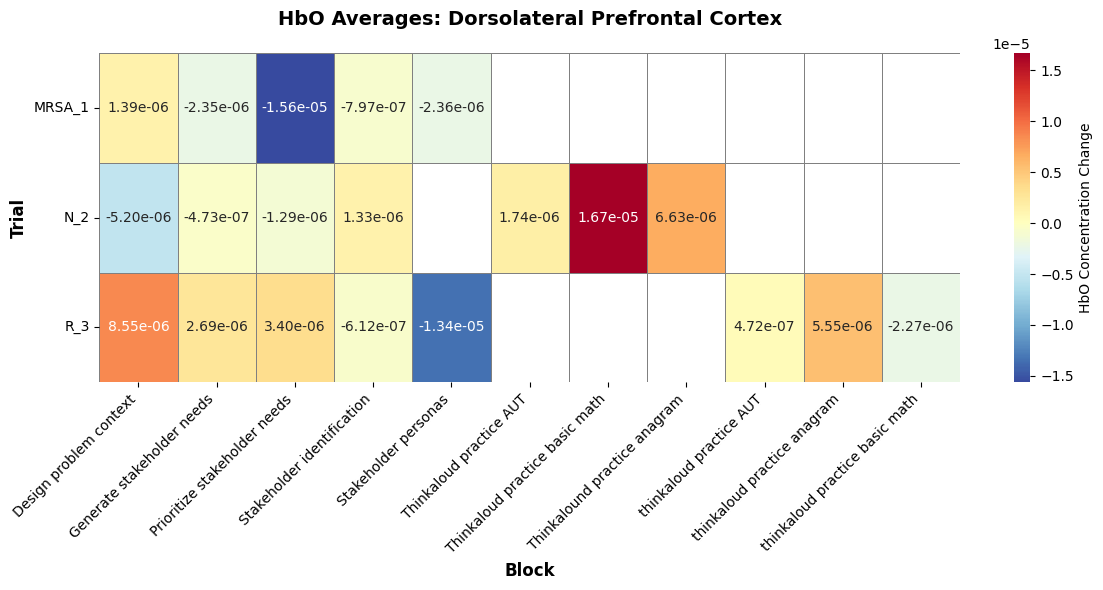

✓ Frontopolar Prefrontal Cortex
  Saved to: ..\reports\figures\heatmap_frontopolar_prefrontal_cortex.png



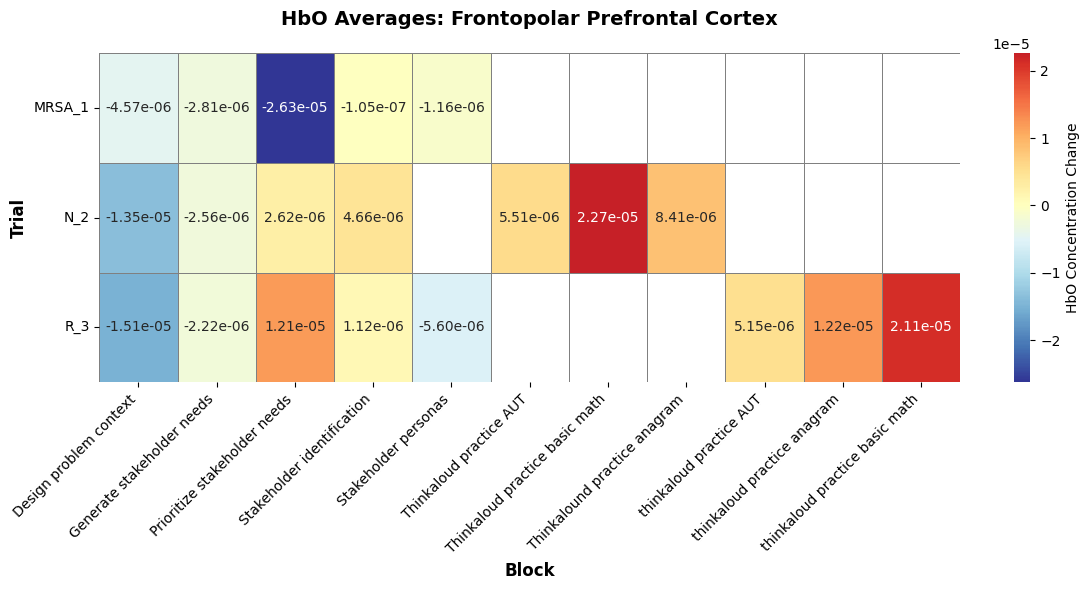

✓ Orbitofrontal Cortex
  Saved to: ..\reports\figures\heatmap_orbitofrontal_cortex.png



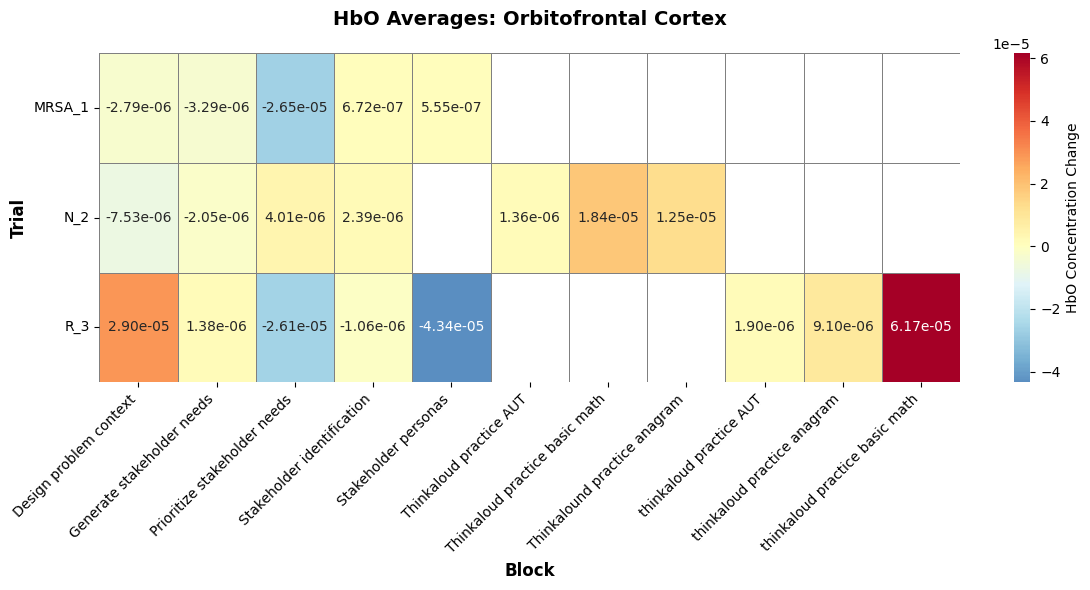

✓ Ventrolateral Prefrontal Cortex
  Saved to: ..\reports\figures\heatmap_ventrolateral_prefrontal_cortex.png



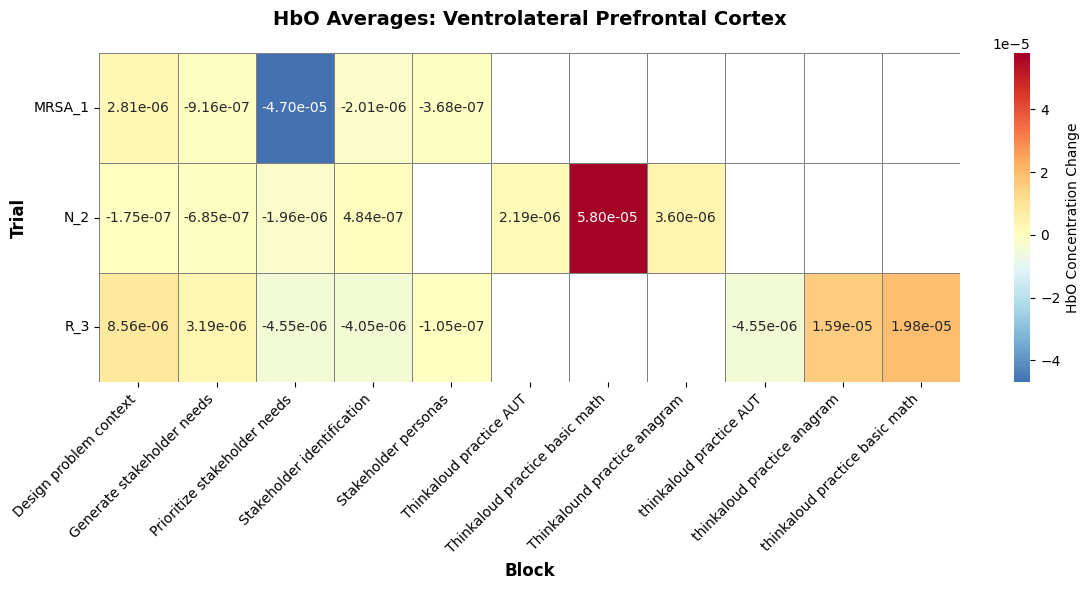

✓ Created 4 heatmaps
All heatmaps saved to: ..\reports\figures


In [ ]:

# Create heatmap visualizations for each brain region
import seaborn as sns
import matplotlib.pyplot as plt

print(f"\n{'='*100}")
print(f"Creating heatmaps for {len(region_pivots)} brain regions")
print(f"{'='*100}\n")

# Create a reports/figures directory if it doesn't exist
figures_dir = "..\\reports\\figures"
os.makedirs(figures_dir, exist_ok=True)

for region_name, pivot_data in region_pivots.items():
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt='.2e',
        cmap='RdYlBu_r',  # Red-Yellow-Blue colormap (reversed so red=high, blue=low)
        center=0,
        cbar_kws={'label': 'HbO Concentration Change'},
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    
    
    ax.set_title(f'HbO Averages: {region_name}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Block', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trial', fontsize=12, fontweight='bold')
    
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure
    safe_region_name = region_name.replace(' ', '_').replace('/', '_').lower()
    figure_path = f"{figures_dir}\\heatmap_{safe_region_name}.png"
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    
    print(f"✓ {region_name}")
    print(f"  Saved to: {figure_path}\n")
    
    # Display the plot
    plt.show()
    
    # Close to free memory
    plt.close()

print(f"{'='*100}")
print(f"✓ Created {len(region_pivots)} heatmaps")
print(f"All heatmaps saved to: {figures_dir}")
print(f"{'='*100}")
